In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from typing import List, Tuple

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml

import tqdm
tqdm.tqdm.pandas()
#plt.style.use('ggplot')

/nfs/staff-ssd/geisler/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from notebooks import mpl_latex

In [5]:
#mpl_latex.enable_production_mode()

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [7]:
labels_to_plot = [
    'Soft Medoid GDC (T=1.0)',
    #'Soft Medoid GDC ($T=0.2$)',
    #'Soft Residual GDC ($T=0.2$)',
    'Vanilla GCN',
    'Vanilla GDC',
    'SVD GCN',
    #'Jaccard GCN',
    #'RGCN'
]

In [8]:
df_experiments = seml.get_results('kdd21_rgnn_at_scale_attack_evasion_transfer_gang_degree',  # global_attack_benchmark
                                  to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])
df_experiments

/nfs/homedirs/geisler/code/seml/seml/evaluation.py:47: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


,_id,batch_id,slurm.experiments_per_job,slurm.sbatch_options.gres,slurm.sbatch_options.mem,slurm.sbatch_options.cpus-per-task,slurm.sbatch_options.time,slurm.sbatch_options.nodes,slurm.sbatch_options.job-name,slurm.sbatch_options.array,slurm.sbatch_options.output,slurm.array_id,slurm.task_id,config.overwrite,config.db_collection,config.dataset,config.attack,config.attack_params.edge_budget,config.attack_params.edge_step_size,config.attack_params.edge_with_random_reverse,config.attack_params.eps,config.attack_params.feature_dedicated_iterations,config.attack_params.feature_greedy_opt,config.attack_params.feature_lr,config.epsilons,config.surrogate_params.n_filters,config.surrogate_params.dropout,config.surrogate_params.train_params.lr,config.surrogate_params.train_params.weight_decay,config.surrogate_params.train_params.patience,config.surrogate_params.train_params.max_epochs,config.binary_attr,config.seed,config.artifact_dir,config.pert_adj_storage_type,config.pert_attr_storage_type,config.model_storage_type,config.device,config.display_steps,config.model_label,result.results
0,1,1,1,gpu:1,16G,4,0-08:00,1,rgnn_at_scale_attack_evasion_transfer_gang_deg...,0-29,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209381,0,1,kdd21_rgnn_at_scale_attack_evasion_transfer_ga...,cora_ml,GANG,5,5,True,1.000000e-16,5,True,0.5,"[0, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,True,0,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur..."
1,2,1,1,gpu:1,16G,4,0-08:00,1,rgnn_at_scale_attack_evasion_transfer_gang_deg...,0-29,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209381,1,2,kdd21_rgnn_at_scale_attack_evasion_transfer_ga...,cora_ml,GANG,10,5,True,1.000000e-16,5,True,0.5,"[0, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,True,0,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur..."
2,3,1,1,gpu:1,16G,4,0-08:00,1,rgnn_at_scale_attack_evasion_transfer_gang_deg...,0-29,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209381,2,3,kdd21_rgnn_at_scale_attack_evasion_transfer_ga...,cora_ml,GANG,20,5,True,1.000000e-16,5,True,0.5,"[0, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,True,0,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur..."
3,4,1,1,gpu:1,16G,4,0-08:00,1,rgnn_at_scale_attack_evasion_transfer_gang_deg...,0-29,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209381,3,4,kdd21_rgnn_at_scale_attack_evasion_transfer_ga...,cora_ml,GANG,50,5,True,1.000000e-16,5,True,0.5,"[0, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,True,0,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur..."
4,5,1,1,gpu:1,16G,4,0-08:00,1,rgnn_at_scale_attack_evasion_transfer_gang_deg...,0-29,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209381,4,5,kdd21_rgnn_at_scale_attack_evasion_transfer_ga...,cora_ml,GANG,100,5,True,1.000000e-16,5,True,0.5,"[0, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,True,0,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur..."
5,6,1,1,gpu:1,16G,4,0-08:00,1,rgnn_at_scale_attack_evasion_transfer_gang_deg...,0-29,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209381,5,6,kdd21_rgnn_at_scale_attack_evasion_transfer_ga...,cora_ml,GANG,200,5,True,1.000000e-16,5,True,0.5,"[0, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,True,0,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur..."
6,7,1,1,gpu:1,16G,4,0-08:00,1,rgnn_at_scale_attack_evasion_transfer_gang_deg...,0-29,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209381,6,7,kdd21_rgnn_at_scale_attack_evasion_transfer_ga...,cora_ml,GANG,5,5,True,1.000000e-16,5,True,0.5,"[0, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,True,1,cache,evasion_transfer_att

In [9]:
df_experiments.columns

Index(['_id', 'batch_id', 'slurm.experiments_per_job',
       'slurm.sbatch_options.gres', 'slurm.sbatch_options.mem',
       'slurm.sbatch_options.cpus-per-task', 'slurm.sbatch_options.time',
       'slurm.sbatch_options.nodes', 'slurm.sbatch_options.job-name',
       'slurm.sbatch_options.array', 'slurm.sbatch_options.output',
       'slurm.array_id', 'slurm.task_id', 'config.overwrite',
       'config.db_collection', 'config.dataset', 'config.attack',
       'config.attack_params.edge_budget',
       'config.attack_params.edge_step_size',
       'config.attack_params.edge_with_random_reverse',
       'config.attack_params.eps',
       'config.attack_params.feature_dedicated_iterations',
       'config.attack_params.feature_greedy_opt',
       'config.attack_params.feature_lr', 'config.epsilons',
       'config.surrogate_params.n_filters', 'config.surrogate_params.dropout',
       'config.surrogate_params.train_params.lr',
       'config.surrogate_params.train_params.weight_decay',
 

In [10]:
df_results = [
    pd.DataFrame(r) 
    for r in df_experiments['result.results']
]
for df_result, (_, df_experiment) in zip(df_results, df_experiments.iterrows()):
    df_result['dataset'] = df_experiment['config.dataset']
    df_result['attack'] = df_experiment['config.attack']
    df_result['edge_budget'] = df_experiment['config.attack_params.edge_budget']
    df_result['seed'] = df_experiment['config.seed']


df_results = pd.concat(df_results, ignore_index=True)
df_results

,label,epsilon,accuracy,dataset,attack,edge_budget,seed
0,Vanilla GCN,0.00,0.815810,cora_ml,GANG,5,0
1,Vanilla GCN,0.10,0.738340,cora_ml,GANG,5,0
2,Vanilla GCN,0.25,0.664822,cora_ml,GANG,5,0
3,Vanilla GDC,0.00,0.833597,cora_ml,GANG,5,0
4,Vanilla GDC,0.10,0.760870,cora_ml,GANG,5,0
...,...,...,...,...,...,...,...
715,Soft Medoid GDC (T=0.5),0.10,0.721344,cora_ml,GANG,200,100
716,Soft Medoid GDC (T=0.5),0.25,0.712253,cora_ml,GANG,200,100
717,Soft Medoid GDC (T=0.2),0.00,0.686957,cora_ml,GANG,200,100
718,Soft Medoid GDC (T=0.2),0.10,0.679447,cora_ml,GANG,200,100


In [11]:
epsilons = [0.1, 0.25]#[0.1, 0.25] #df.epsilon.unique()
line_styles = ['-'] #['-', '--', ':', '-.']

cora_ml
0.1
Vanilla GCN
Vanilla GDC
Soft Medoid GDC (T=1.0)
Soft Medoid GDC (T=0.5)
Soft Medoid GDC (T=0.2)
SVD GCN
Jaccard GCN
RGCN


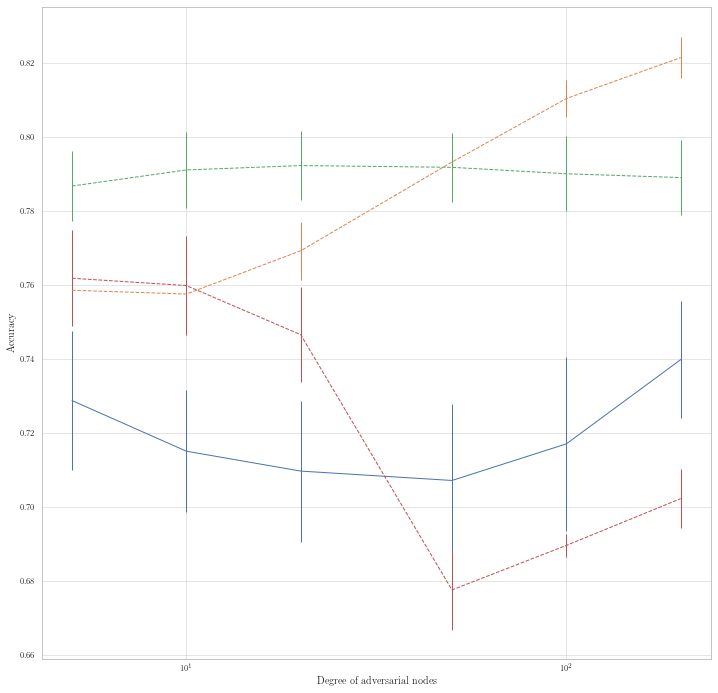

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


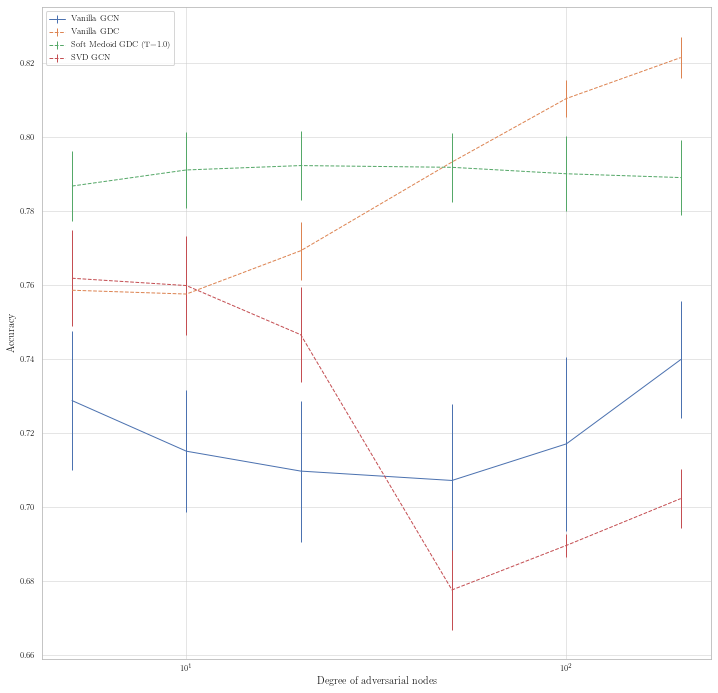

0.25
Vanilla GCN
Vanilla GDC
Soft Medoid GDC (T=1.0)
Soft Medoid GDC (T=0.5)
Soft Medoid GDC (T=0.2)
SVD GCN
Jaccard GCN
RGCN


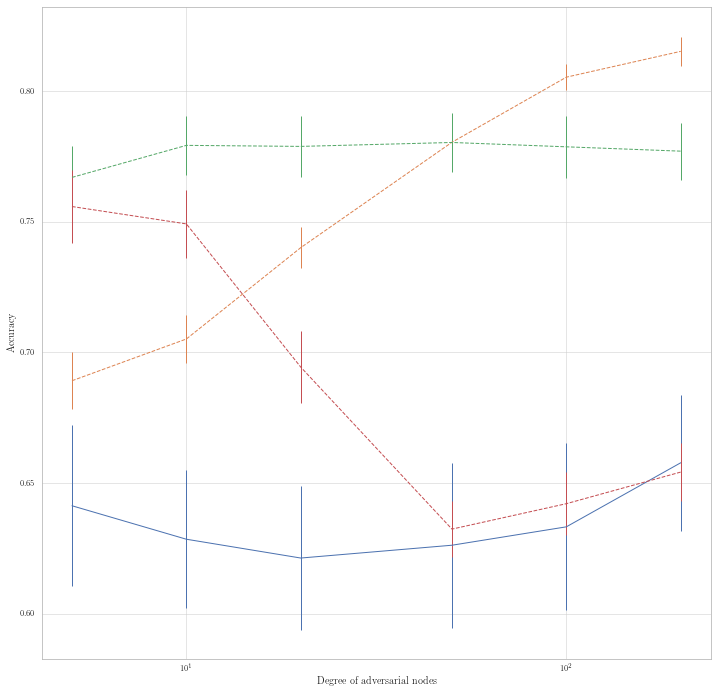

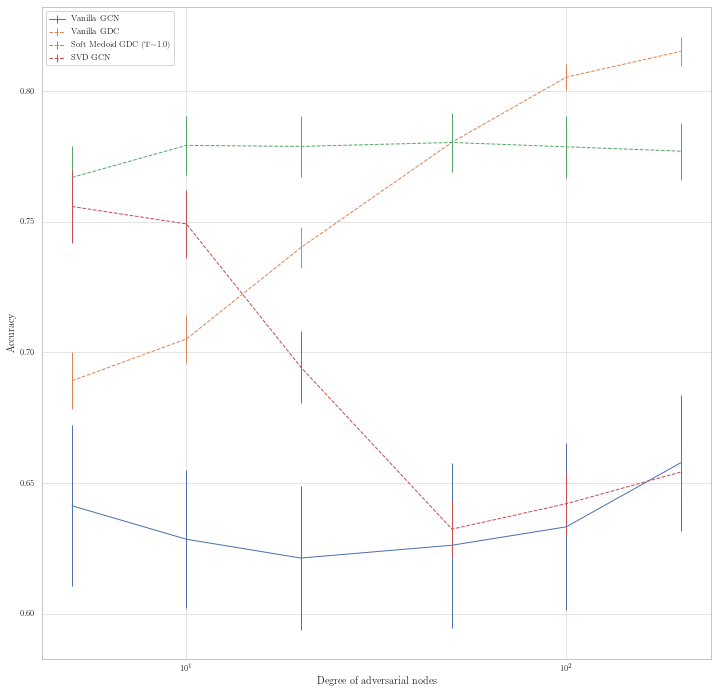

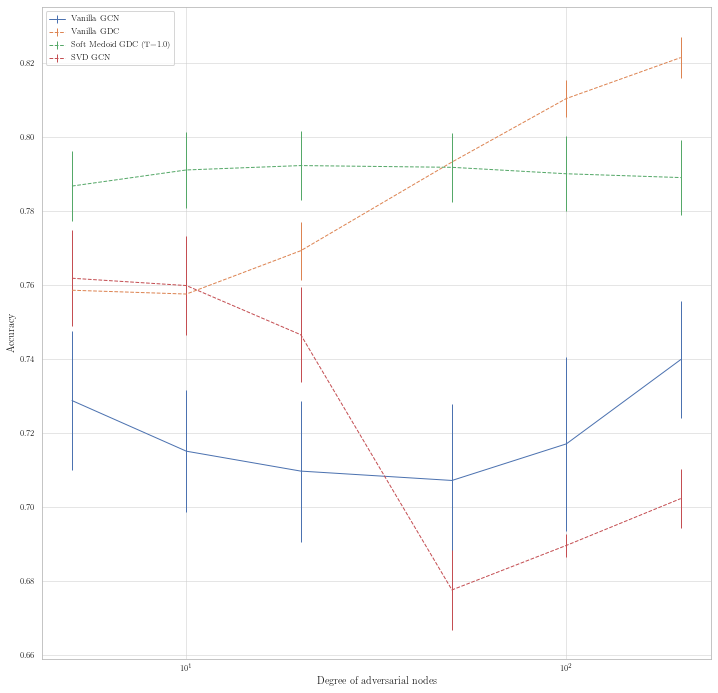

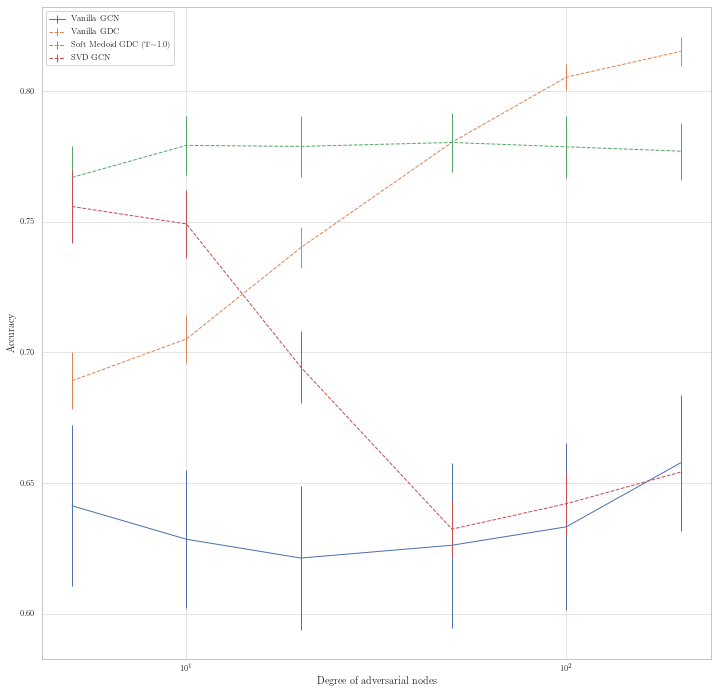

In [12]:
for dataset in df_results.dataset.unique():
    print(dataset)
    for epsilon in epsilons:
        fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)
        print(epsilon)
        for label in df_results.label.unique():
            print(label)
            if label not in labels_to_plot:
                continue
            group = df_results[(df_results.dataset == dataset)
                       & (df_results.label == label)
                       & (df_results.epsilon == epsilon)]

            if not group.shape[0]:
                print(f'No experiment with label {label}, dataset {dataset} and attack {attack} found')
                continue

            accs = group.groupby('edge_budget').accuracy.mean()
            sizes = group.groupby('edge_budget').accuracy.size()
            acc_error = 3*group.groupby('edge_budget').accuracy.agg(lambda accs: accs.std()) / sizes

            plt.errorbar(
                accs.index,
                accs,
                acc_error,
                label=label.replace(' ($T=1.0$)', ''),
                linestyle='-' if label == 'Vanilla GCN' else '--'#selected_experiments.get_linestyle(label)
            )
        plt.gca().set_prop_cycle(None)

        #plt.title(f'Dataset={dataset}, Attack={attack_names[attack]}'.replace('_', ' '))
        plt.ylabel('Accuracy')
        plt.xlabel('Degree of adversarial nodes')
        plt.xscale('log')
        mpl_latex.savefig(f'latex/assets/global_gang_{dataset}_{epsilon}_node_degree_no_legend', fig, close_fig=False)
        plt.legend()
        mpl_latex.savefig(f'latex/assets/global_gang_{dataset}_{epsilon}_node_degree', fig, close_fig=False)
        mpl_latex.dedicated_legend_plot(
            f'latex/assets/global_gang_{dataset}_{epsilon}_node_degree_legend',
            mod_label=lambda l: l,
            ncol=2
        )